# Clustering

Suppose that you have several samples each of which is characterized by a certain set of features (like individuals characterized by their height and weight.) Clustering is a task to divide such sample sets into **several different groups**. Let's use k-means clustering, one of the famous clustering methods.

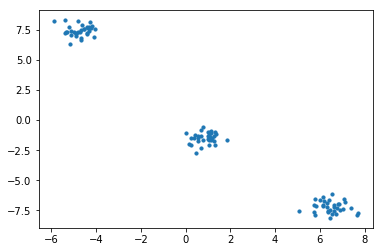

In [2]:
from sklearn.datasets import make_blobs # sample generator
import matplotlib.pyplot as plt
%matplotlib inline

x, _ = make_blobs(cluster_std=.5)
plt.scatter(x[:, 0], x[:, 1], 10)

Looks like the samples shown above have three different groups. k-means clustering tries to divide samples into $k$ disjoint clusters by the following procedures.

1. (initialization) ramdomly generate $k$ cluster centroids.
2. (assignment) assign eaach sample to the closest cluster.
3. (cluster update) for each cluster, replace the cluster center by the mean of samples assigned to that cluster.
4. iterate 2. and 3.

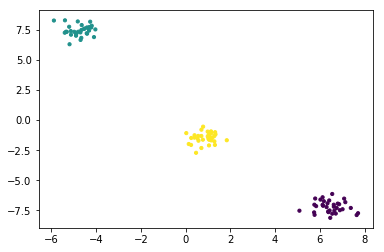

In [3]:
from sklearn.cluster import MiniBatchKMeans

KM = MiniBatchKMeans(n_clusters=3)
idx = KM.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], 10, idx)

## Exercises
- Change `n_samples` and `cluster_std` in `make_blobs` to see how generated samples follow different distributions and how k-means clustering produdes different results accordingly.
- k-means clustering requires $k$ to be defined by users in advance. Change `n_clusters` in `KMeans` to see how assingment results and computation speeds change accordingly.
- Investigate and discuss how to define *appropriate* `k`.

# Application of Clustering 1: Superpixel Segmentation

Superpixel segmentation is an image processing method that decomposes given images into several small regions (subpixels). **SLIC** is one of the state-of-the-art superpixel segmentation methods based on k-means clustering. In SLIC, superpixels are defined by a set of pixels which have similar color and are close to each other. Namely, we can obtain superpixels by regarding pixels as samples chracterized by their location and color, and running k-means clustering on those samples.

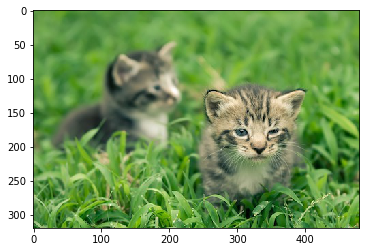

In [4]:
from skimage.io import imread
import numpy as np

img = imread('data/cat.jpg')
plt.imshow(img)

Let's first use `np.meshgrid` to obtain locations of each pixel

In [17]:
x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
print('\n x:\n', x)
print('\n y:\n', y)

loc = np.vstack((x.flatten(), y.flatten())).T
print('\n (x, y):\n', loc)


 x:
 [[  0   1   2 ... 477 478 479]
 [  0   1   2 ... 477 478 479]
 [  0   1   2 ... 477 478 479]
 ...
 [  0   1   2 ... 477 478 479]
 [  0   1   2 ... 477 478 479]
 [  0   1   2 ... 477 478 479]]

 y:
 [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [317 317 317 ... 317 317 317]
 [318 318 318 ... 318 318 318]
 [319 319 319 ... 319 319 319]]

 (x, y):
 [[  0   0]
 [  1   0]
 [  2   0]
 ...
 [477 319]
 [478 319]
 [479 319]]


In SLIC, color of each pixel is represented in the Lab color space. The color transform from rgb to lab can be done with `skimage.color.rgb2lab`.

In [16]:
from skimage.color import rgb2lab
img_lab = rgb2lab(img)
color = img_lab.reshape((img.shape[0] * img.shape[1], 3))

print('\n (l, a, b):\n', color)


 (l, a, b):
 [[ 57.78608491 -34.22358504  36.44151753]
 [ 57.78608491 -34.22358504  36.44151753]
 [ 57.78608491 -34.22358504  36.44151753]
 ...
 [ 53.58044219 -19.06362387  26.64737598]
 [ 53.51878773 -15.34576235  31.04355674]
 [ 43.38923083 -14.74586524  35.71690473]]


Samples are then given by concatenating locations and colors. Let's run k-means to get superpixels! Since we do not know appropriate number of superpixels in advance, let's try `n_clusters=50` for now. In the cell below, `idx` represents an idx of each superpixel; pixels having the same idx belong to the same superpixel.

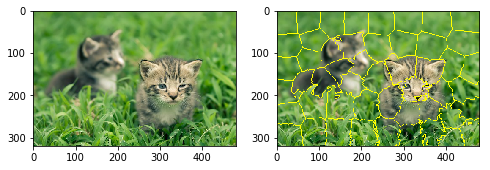

In [21]:
sample = np.hstack((loc, color))

KM = MiniBatchKMeans(n_clusters=50)
idx = KM.fit_predict(sample)

sp = idx.reshape((img.shape[0], img.shape[1]))  # reshape the sequence of indices to have the 2d image form

from skimage.segmentation import mark_boundaries  # useful funtion for visualizing superpixels
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(img, sp))

### Exercises
- Change image sizes and the number of superpixels to see how results and computation times change.
- Try optimized SLIC function implemented in `skimage.segmentation.slic` and compare results and computation times.

# Application of Clustering 2: Salient Object Detection

Salient object detection is a method to automatically extract saient (i.e., important) regions from given images. Let's implement a simple salient object detection method based on superpixel segmentation and color statistics. For now we assume that superpixels with rare color are likely to be a part of important regions in a given image.

In [22]:
sp_ = sp.flatten()
color = rgb2lab(img).reshape((img.shape[0] * img.shape[1], 3))
color_sp = np.vstack([color[sp_ == x].mean(axis=0) 
                      for x in np.unique(sp_)])  # average color for each superpixel

In order to judge the rarity of each superpixel color, we need a probability distribution describing what colors are/are not likely to appear in a given image (e.g., 70% red, 30% green,...). Here, let's use a kernel density estimation implemented in `sklearn.neighbors.KernelDensity`.

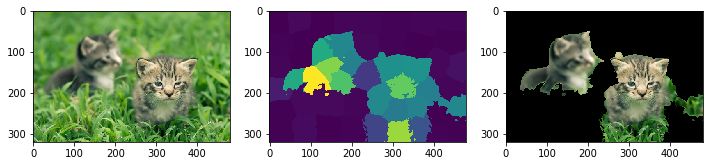

In [24]:
from sklearn.neighbors import KernelDensity

kd = KernelDensity(bandwidth=1e1)
kd.fit(color_sp)  # Estimating color probability distribution with the kernel density estimation
color_prob = np.exp(kd.score_samples(color_sp))  # Computing log probability of each color.
importance = 1. / color_prob  # Defining rariry by the inverse of color probability.
so = importance[sp_].reshape((img.shape[0], img.shape[1]))  # transforming importance to have the image form

plt.figure(figsize=[12, 8])
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(so)
plt.subplot(1, 3, 3)
img_ = img.copy()
img_[so < np.mean(so)] = 0
plt.imshow(img_)

## Execises
- Apply the above method to various images and discuss in which cases you can obtain intuitive or counter-intuitive results.
- Change the number of superpixes and the bandwidth of KDE to see how results change.
- Implement a function that runs as follows:
  1. Load a video as input and extract salient objects for each frame independently.
  2. Estimate the number of salient object *instances* as well as the number of salient object *classes*. For example, the image above has two salient object instances (two cats) and one salient object class (cat).